In [109]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import progressbar
import plotly.graph_objs as go
import plotly.plotly as py
from math import sin, cos, sqrt, atan2, radians, pi
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

In [110]:
source_dir = "./Data/"
#plt.style.use('seaborn')

## FUNCTIONS

In [111]:
tstamp_fmt = '%Y-%m-%d %H:%M:%S'

In [112]:
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

##### Validate Format of Timestamps

In [113]:
# returnes order_ids to be trashed because of invalid format
def validate_fmt(ord_id, date_text):
    try:
        dt.datetime.strptime(date_text, tstamp_fmt)
    except ValueError:
        return ord_id
        # print(f"{ord_id} wrong datatype")
        #raise ValueError("Incorrect data format, should be YYYY-MM-DD hh:mm:ss")

##### Get Differences On Timestamps

In [114]:
# returns the difference between two timestamps in minutes
def elapsed_time(ord_id, t1, t2):
    t2 = dt.datetime.strptime(t2, tstamp_fmt)
    t1 = dt.datetime.strptime(t1, tstamp_fmt)
    if t2>t1:
        td = t2 - t1
        td_mins = round(td.total_seconds() / 60, 2) 
        return [ord_id, td_mins]
    elif t2==t1:
        return [ord_id, 1.0] #this line is to be used for deliveries of just 1 item
    else:
        return [ord_id, np.NaN]

#### Alternative Form of the Function Above

In [115]:
# returns order_ids to be trashed because of issues with differences between timestamps
def junk_time(ord_id, t1, t2):
    t2 = dt.datetime.strptime(t2, tstamp_fmt)
    t1 = dt.datetime.strptime(t1, tstamp_fmt)
    if t2>t1: 
        pass
    else:
        return ord_id

#### Compute Distances from Lat-Lng values to compare with GOOGLE API (not saying google can be wrong...)

In [116]:
# return distance calculated from latitude and longitude
def dist_calc(x,y):
    if not isinstance(x, list):
        print(f"provide lat and lon for {x}")
    if not isinstance(y, list):
        print(f"provide lat and lon for {y}")
    
    R = 6373.0
    lat1 = radians(x[0])
    lon1 = radians(x[1])
    lat2 = radians(y[0])
    lon2 = radians(y[1])
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c * 1000
    return distance

# DATA LOADING & CLEANING


### COURIER TABLE

In [117]:
cour_head = ['id', 'enabled', 'soldo_enabled', 'area', 'orders_taken', 'orders_sent', 'created_at', 'updated_at']
df_cour = pd.read_csv(filepath_or_buffer="./Data/courier.csv")
df_cour.columns = cour_head
print("Overview of Courier Table")
df_cour.head()

Overview of Courier Table


,id,enabled,soldo_enabled,area,orders_taken,orders_sent,created_at,updated_at
0,9,0,0,VR1,0,0,2014-09-03 12:40:58,2016-08-24 16:33:11
1,10,0,0,VR1,0,0,2014-09-03 12:40:58,2018-10-05 12:31:14
2,13,0,0,VR1,0,0,2014-09-03 12:40:58,2018-10-05 12:31:14
3,14,0,0,VR1,0,0,2014-09-03 12:40:58,2015-04-26 13:13:55
4,15,0,0,VR1,0,0,2014-09-03 12:40:58,2018-10-17 01:10:06


In [118]:
df_cour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78883 entries, 0 to 78882
Data columns (total 8 columns):
id               78883 non-null int64
enabled          78883 non-null int64
soldo_enabled    78883 non-null int64
area             78883 non-null object
orders_taken     78883 non-null int64
orders_sent      78883 non-null int64
created_at       78883 non-null object
updated_at       78883 non-null object
dtypes: int64(5), object(3)
memory usage: 4.8+ MB


In [119]:
types_cour = df_cour.columns.to_series().groupby(df_cour.dtypes).groups
types_cour

{dtype('int64'): Index(['id', 'enabled', 'soldo_enabled', 'orders_taken', 'orders_sent'], dtype='object'),
 dtype('O'): Index(['area', 'created_at', 'updated_at'], dtype='object')}

### COURIER ROLE TABLE

In [120]:
cour_role_head = ['id', 'courier_id', 'role_id']
df_role = pd.read_csv(filepath_or_buffer="./Data/courier_role.csv")
df_role.columns = cour_role_head
print("Overview of Courier Role Table")
df_role.head()

Overview of Courier Role Table


,id,courier_id,role_id
0,205199,9,2
1,234,10,2
2,236,13,2
3,238,14,2
4,224307,15,2


In [121]:
types_role = df_role.columns.to_series().groupby(df_role.dtypes).groups
types_role

{dtype('int64'): Index(['id', 'courier_id', 'role_id'], dtype='object')}

### CUSTOMER TABLE

In [122]:
customer_head = ['id', 'province', 'lat', 'lng', 'area', 'ztl', 'ref_id', 'has_subscription', 'created_at', 'updated_at']
df_cust = pd.read_csv(filepath_or_buffer="./Data/customer.csv")
df_cust.columns = customer_head
print(df_cust.shape)
df_cust.head()

(388907, 10)


,id,province,lat,lng,area,ztl,ref_id,has_subscription,created_at,updated_at
0,52,MO,44.653089,10.953185,\N,0,33152,0,20/05/2015 17:47,20/05/2015 17:47
1,58,RM,41.899597,12.431724,\N,0,33220,0,21/05/2015 08:39,21/05/2015 08:39
2,60,MI,45.500228,9.237602,\N,0,18072,0,21/05/2015 09:39,21/05/2015 09:39
3,62,RM,41.860709,12.482966,\N,0,28560,0,21/05/2015 10:23,21/05/2015 10:23
4,74,TO,45.077591,7.633557,\N,0,33428,0,22/05/2015 11:39,22/05/2015 11:39


In [123]:
types_cust = df_cust.columns.to_series().groupby(df_cust.dtypes).groups
types_cust

{dtype('int64'): Index(['id', 'ztl', 'ref_id', 'has_subscription'], dtype='object'),
 dtype('float64'): Index(['lat', 'lng'], dtype='object'),
 dtype('O'): Index(['province', 'area', 'created_at', 'updated_at'], dtype='object')}

### ORDER TABLE

In [124]:
order_head = ['id', 'store_id', 'customer_id', 'courier_id', 'picker_id', 'fulfillment_type', 'status', 'deliver_at_start', 'deliver_at_end', 'amount', 'volume', 'delivery_cost_fixed_original', 'delivery_cost_discount', 'store_customer_distance', 'store_customer_duration', 'delivery_moved', 'deleted', 'gdo', 'vertical', 'created_at', 'updated_at', 'assigned_at', 'picked_at', 'paid_at', 'delivered_at', 'deleted_at']
%time df_order = pd.read_csv(filepath_or_buffer="./Data/order.csv")
df_order.columns = order_head
print("Shape ", df_order.shape)
df_order.head()

CPU times: user 2.1 s, sys: 190 ms, total: 2.29 s
Wall time: 2.29 s
Shape  (388907, 26)


<string>:2: DtypeWarning:

Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.



,id,store_id,customer_id,courier_id,picker_id,fulfillment_type,status,deliver_at_start,deliver_at_end,amount,...,deleted,gdo,vertical,created_at,updated_at,assigned_at,picked_at,paid_at,delivered_at,deleted_at
0,20050,52,52,4393,\N,1,600,2015-05-20 19:00:00,2015-05-20 20:00:00,19.98,...,0,0,0,2015-05-20 17:47:58,2018-10-03 15:38:03,2015-05-20 18:45:08,\N,2015-05-20 19:38:41,2015-05-20 19:53:49,\N
1,20056,58,58,4701,\N,1,600,2015-05-22 19:00:00,2015-05-22 20:00:00,14.64,...,0,0,0,2015-05-21 08:39:31,2018-10-03 15:38:03,2015-05-21 19:52:31,\N,2015-05-22 18:52:12,2015-05-22 19:07:51,\N
2,20058,60,60,14816,\N,1,600,2015-05-21 15:00:00,2015-05-21 16:00:00,31.09,...,0,0,0,2015-05-21 09:39:06,2018-10-03 15:38:03,2015-05-21 11:02:51,\N,2015-05-21 15:43:21,2015-05-21 17:23:48,\N
3,20060,62,62,7270,\N,1,600,2015-05-21 18:00:00,2015-05-21 19:00:00,29.79,...,0,0,0,2015-05-21 10:23:26,2018-10-03 15:38:03,2015-05-21 12:17:45,\N,2015-05-21 18:03:32,2015-05-21 20:19:08,\N
4,20072,74,74,5267,\N,1,600,2015-05-22 13:00:00,2015-05-22 14:00:00,16.79,...,0,0,0,2015-05-22 11:39:21,2018-10-03 15:38:03,2015-05-22 12:35:41,\N,2015-05-22 14:37:35,2015-05-22 14:45:03,\N


In [125]:
types_ord = df_order.columns.to_series().groupby(df_order.dtypes).groups
types_ord

{dtype('int64'): Index(['id', 'store_id', 'customer_id', 'fulfillment_type', 'status',
        'store_customer_distance', 'delivery_moved', 'deleted', 'gdo',
        'vertical'],
       dtype='object'),
 dtype('float64'): Index(['amount', 'volume', 'delivery_cost_fixed_original',
        'delivery_cost_discount'],
       dtype='object'),
 dtype('O'): Index(['courier_id', 'picker_id', 'deliver_at_start', 'deliver_at_end',
        'store_customer_duration', 'created_at', 'updated_at', 'assigned_at',
        'picked_at', 'paid_at', 'delivered_at', 'deleted_at'],
       dtype='object')}

#### Get subset where STORE_CUSTOMER_DURATION is not empty

In [126]:
scd = df_order[['id','store_customer_duration']]
scd.head()
scd_nan = pd.to_numeric(scd['store_customer_duration'], errors='coerce')
scd_nan = scd_nan.dropna()
scd_nan.index

## subset data with store_customer_duration estimated
df_order_scd = df_order.iloc[scd_nan.index]

#### Filter out DELETED orders and filter the data with STATUS>=500

In [127]:
## filter out deleted orders 
## deleted "deleted_at" column
## filter just delivered orders
df_order_scd = df_order_scd[df_order_scd.deleted == 0]
df_order_scd = df_order_scd.drop(['deleted_at'], axis=1)
df_order_scd = df_order_scd[df_order_scd.status >= 500].drop('updated_at', axis=1)
print("Shape ", df_order_scd.shape)
df_order_scd.head()

Shape  (296631, 24)


,id,store_id,customer_id,courier_id,picker_id,fulfillment_type,status,deliver_at_start,deliver_at_end,amount,...,store_customer_duration,delivery_moved,deleted,gdo,vertical,created_at,assigned_at,picked_at,paid_at,delivered_at
47399,120402,100438,100446,42378,\N,1,600,2016-05-10 13:00:00,2016-05-10 14:00:00,35.51,...,198,0,0,0,0,2016-05-10 00:15:58,2016-05-10 00:16:47,\N,2016-05-10 13:34:11,2016-05-10 13:40:33
47400,120404,100440,100448,51236,\N,1,600,2016-05-12 20:00:00,2016-05-12 21:00:00,29.13,...,661,0,0,0,0,2016-05-10 00:38:32,2016-05-10 00:42:31,\N,2016-05-12 20:07:18,2016-05-12 20:27:28
47401,120406,100442,100450,32934,\N,1,600,2016-05-10 13:00:00,2016-05-10 14:00:00,21.65,...,235,0,0,0,0,2016-05-10 00:55:42,2016-05-10 00:57:00,\N,2016-05-10 12:53:48,2016-05-10 13:06:30
47402,120408,100444,100452,53458,\N,1,600,2016-05-10 10:00:00,2016-05-10 11:00:00,22.83,...,951,0,0,0,0,2016-05-10 01:03:26,2016-05-10 08:47:28,\N,2016-05-10 10:29:41,2016-05-10 11:00:07
47403,120410,100446,100454,36412,\N,1,600,2016-05-10 12:00:00,2016-05-10 13:00:00,124.03,...,686,0,0,0,0,2016-05-10 03:04:37,2016-05-10 03:17:08,\N,2016-05-10 12:14:33,2016-05-10 12:37:22


#### Validate orders delivered_at format

In [128]:
junk_ord = np.array(list(map(validate_fmt,df_order_scd.id.values,df_order_scd.delivered_at.values)))
print(junk_ord[:20])
junk_ord = junk_ord[junk_ord != np.array(None)].astype(int)
print("Number of orders with no delivered_at keyword ", len(junk_ord))

[None None None None None None None None None None None None None None
 None None None None None None]
Number of orders with no delivered_at keyword  0


#### Validate orders paid_at format

In [129]:
junk_ord = np.array(list(map(validate_fmt,df_order_scd.id.values,df_order_scd.paid_at.values)))
print(junk_ord[:20])
junk_ord = junk_ord[junk_ord != np.array(None)].astype(int)
print("Number of orders with no paid_at keyword ", len(junk_ord))

[None None None None None None None None None None None None None None
 None None None None None None]
Number of orders with no paid_at keyword  0


### ORDER TIMESTAMP TABLE

In [130]:
order_time_head = ['order_id', 'opened_at', 'client_synced_at', 'synced_at', 'first_detail_picked_at', 'last_detail_picked_at', 'first_try_pay_at', 'delivered_at']
%time df_tstamp = pd.read_csv(filepath_or_buffer="./Data/order_timestamps.csv")
df_tstamp.columns = order_time_head
print("Shape ", df_tstamp.shape)
df_tstamp.head()

CPU times: user 1.02 s, sys: 139 ms, total: 1.16 s
Wall time: 1.16 s
Shape  (388907, 8)


,order_id,opened_at,client_synced_at,synced_at,first_detail_picked_at,last_detail_picked_at,first_try_pay_at,delivered_at
0,20050,\N,\N,\N,\N,\N,\N,\N
1,20056,\N,\N,\N,\N,\N,\N,\N
2,20058,\N,\N,\N,\N,\N,\N,\N
3,20060,\N,\N,\N,\N,\N,\N,\N
4,20072,\N,\N,\N,\N,\N,\N,\N


In [131]:
types_tstamp = df_tstamp.columns.to_series().groupby(df_tstamp.dtypes).groups
types_tstamp

{dtype('int64'): Index(['order_id'], dtype='object'),
 dtype('O'): Index(['opened_at', 'client_synced_at', 'synced_at', 'first_detail_picked_at',
        'last_detail_picked_at', 'first_try_pay_at', 'delivered_at'],
       dtype='object')}

#### CHECK if ORDER_IDs in TIMESTAMPS and IDs in ORDERS match 
If TRUE, subset TIMESTAMPS dataset

In [132]:
df_order.id.equals(df_tstamp.order_id)

True

#### Filter order timestamps according to main orders table

In [133]:
df_tstamp_scd = df_tstamp.iloc[df_order_scd.index]
df_tstamp_scd.head(10)

,order_id,opened_at,client_synced_at,synced_at,first_detail_picked_at,last_detail_picked_at,first_try_pay_at,delivered_at
47399,120402,2016-05-10 13:17:32,2016-05-10 13:17:31,2016-05-10 13:17:32,2016-05-10 13:18:10,2016-05-10 13:33:54,2016-05-10 13:34:10,\N
47400,120404,2016-05-12 19:23:04,2016-05-12 19:23:04,2016-05-12 19:23:04,2016-05-12 19:26:02,2016-05-12 19:58:00,2016-05-12 20:07:17,\N
47401,120406,\N,\N,\N,\N,\N,\N,\N
47402,120408,2016-05-10 10:08:38,2016-05-10 10:08:37,2016-05-10 10:08:38,2016-05-10 10:09:44,2016-05-10 10:19:06,2016-05-10 10:29:39,\N
47403,120410,2016-05-10 10:04:47,2016-05-10 10:04:47,2016-05-10 10:04:47,2016-05-10 10:30:48,2016-05-10 11:48:41,2016-05-10 12:14:32,\N
47405,120414,2016-05-10 10:21:04,2016-05-10 10:21:03,2016-05-10 10:21:04,2016-05-10 10:23:56,2016-05-10 10:36:16,2016-05-10 10:50:05,\N
47406,120416,2016-05-10 13:51:09,2016-05-10 13:51:07,2016-05-10 13:51:09,2016-05-10 13:52:40,2016-05-10 14:26:52,2016-05-10 14:38:29,\N
47407,120418,2016-05-13 09:13:18,2016-05-13 09:13:19,2016-05-13 09:13:18,2016-05-13 09:27:30,2016-05-13 09:40:15,2016-05-13 09:54:15,\N
47410,120424,2016-05-10 09:08:18,2016-05-10 09:08:41,2016-05-10 09:08:18,2016-05-10 09:54:04,2016-05-10 10:19:34,2016-05-10 10:30:18,\N
47412,120428,2016-05-10 13:58:04,2016-05-10 13:58:04,2016-05-10 13:58:04,2016-05-10 14:16:59,2016-05-10 14:34:37,2016-05-10 14:34:56,\N


#### Remove from the datasets the order_ids where there's no timestamp of the order being opened
Those would not allow to estimate the picking time

In [134]:
junk_not_open = np.array(list(map(validate_fmt,df_tstamp_scd.order_id.values,df_tstamp_scd.opened_at.values)))
junk_not_open[:20]

array([None, None, 120406, None, None, None, None, None, None, None, None,
       None, None, None, None, None, None, None, None, None], dtype=object)

In [135]:
junk_not_open = junk_not_open[junk_not_open != np.array(None)].astype(int)
print("Number of orders with no opened_at keyword ", len(junk_not_open))

Number of orders with no opened_at keyword  5933


In [136]:
df_tstamp_opened = df_tstamp_scd[~df_tstamp_scd.order_id.isin(junk_not_open)]
print("Shape ", df_tstamp_opened.shape)
df_tstamp_opened.head(10)

Shape  (290698, 8)


,order_id,opened_at,client_synced_at,synced_at,first_detail_picked_at,last_detail_picked_at,first_try_pay_at,delivered_at
47399,120402,2016-05-10 13:17:32,2016-05-10 13:17:31,2016-05-10 13:17:32,2016-05-10 13:18:10,2016-05-10 13:33:54,2016-05-10 13:34:10,\N
47400,120404,2016-05-12 19:23:04,2016-05-12 19:23:04,2016-05-12 19:23:04,2016-05-12 19:26:02,2016-05-12 19:58:00,2016-05-12 20:07:17,\N
47402,120408,2016-05-10 10:08:38,2016-05-10 10:08:37,2016-05-10 10:08:38,2016-05-10 10:09:44,2016-05-10 10:19:06,2016-05-10 10:29:39,\N
47403,120410,2016-05-10 10:04:47,2016-05-10 10:04:47,2016-05-10 10:04:47,2016-05-10 10:30:48,2016-05-10 11:48:41,2016-05-10 12:14:32,\N
47405,120414,2016-05-10 10:21:04,2016-05-10 10:21:03,2016-05-10 10:21:04,2016-05-10 10:23:56,2016-05-10 10:36:16,2016-05-10 10:50:05,\N
47406,120416,2016-05-10 13:51:09,2016-05-10 13:51:07,2016-05-10 13:51:09,2016-05-10 13:52:40,2016-05-10 14:26:52,2016-05-10 14:38:29,\N
47407,120418,2016-05-13 09:13:18,2016-05-13 09:13:19,2016-05-13 09:13:18,2016-05-13 09:27:30,2016-05-13 09:40:15,2016-05-13 09:54:15,\N
47410,120424,2016-05-10 09:08:18,2016-05-10 09:08:41,2016-05-10 09:08:18,2016-05-10 09:54:04,2016-05-10 10:19:34,2016-05-10 10:30:18,\N
47412,120428,2016-05-10 13:58:04,2016-05-10 13:58:04,2016-05-10 13:58:04,2016-05-10 14:16:59,2016-05-10 14:34:37,2016-05-10 14:34:56,\N
47413,120430,2016-05-10 09:56:59,2016-05-10 09:57:00,2016-05-10 09:56:59,2016-05-10 10:01:42,2016-05-10 10:41:34,2016-05-10 11:03:19,\N


In [137]:
df_order_opened = df_order_scd[~df_order_scd.id.isin(junk_not_open)]
print("Shape ", df_order_opened.shape)
df_order_opened.head(10)

Shape  (290698, 24)


,id,store_id,customer_id,courier_id,picker_id,fulfillment_type,status,deliver_at_start,deliver_at_end,amount,...,store_customer_duration,delivery_moved,deleted,gdo,vertical,created_at,assigned_at,picked_at,paid_at,delivered_at
47399,120402,100438,100446,42378,\N,1,600,2016-05-10 13:00:00,2016-05-10 14:00:00,35.51,...,198,0,0,0,0,2016-05-10 00:15:58,2016-05-10 00:16:47,\N,2016-05-10 13:34:11,2016-05-10 13:40:33
47400,120404,100440,100448,51236,\N,1,600,2016-05-12 20:00:00,2016-05-12 21:00:00,29.13,...,661,0,0,0,0,2016-05-10 00:38:32,2016-05-10 00:42:31,\N,2016-05-12 20:07:18,2016-05-12 20:27:28
47402,120408,100444,100452,53458,\N,1,600,2016-05-10 10:00:00,2016-05-10 11:00:00,22.83,...,951,0,0,0,0,2016-05-10 01:03:26,2016-05-10 08:47:28,\N,2016-05-10 10:29:41,2016-05-10 11:00:07
47403,120410,100446,100454,36412,\N,1,600,2016-05-10 12:00:00,2016-05-10 13:00:00,124.03,...,686,0,0,0,0,2016-05-10 03:04:37,2016-05-10 03:17:08,\N,2016-05-10 12:14:33,2016-05-10 12:37:22
47405,120414,100450,100458,1149,\N,1,600,2016-05-10 10:00:00,2016-05-10 11:00:00,28.30,...,741,0,0,0,0,2016-05-10 06:44:35,2016-05-10 07:05:43,\N,2016-05-10 10:50:06,2016-05-10 11:12:35
47406,120416,100452,100460,48948,\N,1,600,2016-05-10 15:00:00,2016-05-10 16:00:00,92.63,...,460,0,0,0,0,2016-05-10 06:52:50,2016-05-10 06:59:00,\N,2016-05-10 14:38:29,2016-05-10 15:09:16
47407,120418,100454,100462,53176,\N,1,600,2016-05-13 10:00:00,2016-05-13 11:00:00,12.72,...,570,0,0,0,0,2016-05-10 06:58:17,2016-05-10 07:01:28,\N,2016-05-13 09:54:19,2016-05-13 10:09:27
47410,120424,100460,100468,55384,\N,1,600,2016-05-10 10:00:00,2016-05-10 11:00:00,24.98,...,671,0,0,0,0,2016-05-10 07:41:57,2016-05-10 07:45:56,\N,2016-05-10 10:30:18,2016-05-10 10:59:02
47412,120428,100464,100472,35964,\N,1,600,2016-05-10 15:00:00,2016-05-10 16:00:00,67.69,...,275,0,0,0,0,2016-05-10 07:46:51,2016-05-10 07:47:46,\N,2016-05-10 14:34:57,2016-05-10 15:05:02
47413,120430,100466,100474,42150,\N,1,600,2016-05-10 12:00:00,2016-05-10 13:00:00,165.16,...,596,0,0,0,0,2016-05-10 07:50:07,2016-05-10 07:59:20,\N,2016-05-10 11:03:23,2016-05-10 11:41:40


In [138]:
df_order_opened.id.equals(df_tstamp_opened.order_id)

True

#### Copy the column delivered_at from orders to timestamps

In [139]:
np.array_equal(df_tstamp_opened.order_id.values, df_order_opened.id)

True

In [140]:
df_tstamp_opened.loc[:,'delivered_at'] = df_order_opened['delivered_at'].values

/Users/gionata/github/analitico/venv/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [141]:
df_tstamp_opened.index.equals(df_order_opened.index)

True

In [142]:
df_tstamp_opened.head()

,order_id,opened_at,client_synced_at,synced_at,first_detail_picked_at,last_detail_picked_at,first_try_pay_at,delivered_at
47399,120402,2016-05-10 13:17:32,2016-05-10 13:17:31,2016-05-10 13:17:32,2016-05-10 13:18:10,2016-05-10 13:33:54,2016-05-10 13:34:10,2016-05-10 13:40:33
47400,120404,2016-05-12 19:23:04,2016-05-12 19:23:04,2016-05-12 19:23:04,2016-05-12 19:26:02,2016-05-12 19:58:00,2016-05-12 20:07:17,2016-05-12 20:27:28
47402,120408,2016-05-10 10:08:38,2016-05-10 10:08:37,2016-05-10 10:08:38,2016-05-10 10:09:44,2016-05-10 10:19:06,2016-05-10 10:29:39,2016-05-10 11:00:07
47403,120410,2016-05-10 10:04:47,2016-05-10 10:04:47,2016-05-10 10:04:47,2016-05-10 10:30:48,2016-05-10 11:48:41,2016-05-10 12:14:32,2016-05-10 12:37:22
47405,120414,2016-05-10 10:21:04,2016-05-10 10:21:03,2016-05-10 10:21:04,2016-05-10 10:23:56,2016-05-10 10:36:16,2016-05-10 10:50:05,2016-05-10 11:12:35


### add columns picking_time, paying_time, delivery_time to df_order dataframe
The aggregate time will represent ETOT for the predictions

1st step: subset the dataset with the 1st_picked detail

In [143]:
junk_1stpick = np.array(list(map(validate_fmt,df_tstamp_opened.order_id.values,df_tstamp_opened.first_detail_picked_at.values)))
junk_1stpick = junk_1stpick[junk_1stpick != np.array(None)].astype(int)
print("Number of orders with no 1st_picked_at keyword ", len(junk_1stpick))

Number of orders with no 1st_picked_at keyword  58331


In [144]:
df_just1stpicked = df_tstamp_opened[~df_tstamp_opened.order_id.isin(junk_1stpick)]
print(df_just1stpicked.shape)
df_just1stpicked.head()

(232367, 8)


,order_id,opened_at,client_synced_at,synced_at,first_detail_picked_at,last_detail_picked_at,first_try_pay_at,delivered_at
47399,120402,2016-05-10 13:17:32,2016-05-10 13:17:31,2016-05-10 13:17:32,2016-05-10 13:18:10,2016-05-10 13:33:54,2016-05-10 13:34:10,2016-05-10 13:40:33
47400,120404,2016-05-12 19:23:04,2016-05-12 19:23:04,2016-05-12 19:23:04,2016-05-12 19:26:02,2016-05-12 19:58:00,2016-05-12 20:07:17,2016-05-12 20:27:28
47402,120408,2016-05-10 10:08:38,2016-05-10 10:08:37,2016-05-10 10:08:38,2016-05-10 10:09:44,2016-05-10 10:19:06,2016-05-10 10:29:39,2016-05-10 11:00:07
47403,120410,2016-05-10 10:04:47,2016-05-10 10:04:47,2016-05-10 10:04:47,2016-05-10 10:30:48,2016-05-10 11:48:41,2016-05-10 12:14:32,2016-05-10 12:37:22
47405,120414,2016-05-10 10:21:04,2016-05-10 10:21:03,2016-05-10 10:21:04,2016-05-10 10:23:56,2016-05-10 10:36:16,2016-05-10 10:50:05,2016-05-10 11:12:35


In [145]:
df_order_opened_1st_pickd = df_order_opened[~df_order_opened.id.isin(junk_1stpick)]

2nd: check last_picked item - this allows to estimate the picking time

In [146]:
junk_lastpick = np.array(list(map(validate_fmt,df_just1stpicked.order_id.values,df_just1stpicked.last_detail_picked_at.values)))
junk_lastpick = junk_lastpick[junk_lastpick != np.array(None)].astype(int)
print("Number of orders with no 1st_picked_at keyword ", len(junk_lastpick))

Number of orders with no 1st_picked_at keyword  31


In [147]:
df_tstmp_clean = df_just1stpicked[~df_just1stpicked.order_id.isin(junk_lastpick)]
print(df_tstmp_clean.shape)
df_tstmp_clean.head()

(232336, 8)


,order_id,opened_at,client_synced_at,synced_at,first_detail_picked_at,last_detail_picked_at,first_try_pay_at,delivered_at
47399,120402,2016-05-10 13:17:32,2016-05-10 13:17:31,2016-05-10 13:17:32,2016-05-10 13:18:10,2016-05-10 13:33:54,2016-05-10 13:34:10,2016-05-10 13:40:33
47400,120404,2016-05-12 19:23:04,2016-05-12 19:23:04,2016-05-12 19:23:04,2016-05-12 19:26:02,2016-05-12 19:58:00,2016-05-12 20:07:17,2016-05-12 20:27:28
47402,120408,2016-05-10 10:08:38,2016-05-10 10:08:37,2016-05-10 10:08:38,2016-05-10 10:09:44,2016-05-10 10:19:06,2016-05-10 10:29:39,2016-05-10 11:00:07
47403,120410,2016-05-10 10:04:47,2016-05-10 10:04:47,2016-05-10 10:04:47,2016-05-10 10:30:48,2016-05-10 11:48:41,2016-05-10 12:14:32,2016-05-10 12:37:22
47405,120414,2016-05-10 10:21:04,2016-05-10 10:21:03,2016-05-10 10:21:04,2016-05-10 10:23:56,2016-05-10 10:36:16,2016-05-10 10:50:05,2016-05-10 11:12:35


In [148]:
df_order_clean = df_order_opened_1st_pickd[~df_order_opened_1st_pickd.id.isin(junk_lastpick)]
print(df_order_clean.shape)
df_order_clean.head()

(232336, 24)


,id,store_id,customer_id,courier_id,picker_id,fulfillment_type,status,deliver_at_start,deliver_at_end,amount,...,store_customer_duration,delivery_moved,deleted,gdo,vertical,created_at,assigned_at,picked_at,paid_at,delivered_at
47399,120402,100438,100446,42378,\N,1,600,2016-05-10 13:00:00,2016-05-10 14:00:00,35.51,...,198,0,0,0,0,2016-05-10 00:15:58,2016-05-10 00:16:47,\N,2016-05-10 13:34:11,2016-05-10 13:40:33
47400,120404,100440,100448,51236,\N,1,600,2016-05-12 20:00:00,2016-05-12 21:00:00,29.13,...,661,0,0,0,0,2016-05-10 00:38:32,2016-05-10 00:42:31,\N,2016-05-12 20:07:18,2016-05-12 20:27:28
47402,120408,100444,100452,53458,\N,1,600,2016-05-10 10:00:00,2016-05-10 11:00:00,22.83,...,951,0,0,0,0,2016-05-10 01:03:26,2016-05-10 08:47:28,\N,2016-05-10 10:29:41,2016-05-10 11:00:07
47403,120410,100446,100454,36412,\N,1,600,2016-05-10 12:00:00,2016-05-10 13:00:00,124.03,...,686,0,0,0,0,2016-05-10 03:04:37,2016-05-10 03:17:08,\N,2016-05-10 12:14:33,2016-05-10 12:37:22
47405,120414,100450,100458,1149,\N,1,600,2016-05-10 10:00:00,2016-05-10 11:00:00,28.30,...,741,0,0,0,0,2016-05-10 06:44:35,2016-05-10 07:05:43,\N,2016-05-10 10:50:06,2016-05-10 11:12:35


2nd step: Create the 3 quantities - picking time, paying time, and delivery time respectively

In [149]:
pick_time = list(map(elapsed_time, df_tstmp_clean.order_id, df_tstmp_clean.first_detail_picked_at, df_tstmp_clean.last_detail_picked_at))
# pick_time

In [150]:
np.isnan(np.array(pick_time)).sum()

9

In [151]:
pay_time = list(map(elapsed_time, df_tstmp_clean.order_id, df_tstmp_clean.last_detail_picked_at, df_order_clean.paid_at))
# pay_time

In [152]:
np.isnan(np.array(pay_time)).sum()

39

In [153]:
delivery_time = list(map(elapsed_time, df_order_clean.id, df_order_clean.paid_at, df_order_clean.delivered_at))
# delivery_time

In [154]:
np.isnan(np.array(delivery_time)).sum()

0

In [155]:
df_temp_pick = pd.DataFrame(np.column_stack([[int(item[0]) for item in pick_time],[float(item[1]) for item in pick_time]]), columns=['id', 'picking_time'])
df_temp_pay = pd.DataFrame(np.column_stack([[int(item[0]) for item in pay_time],[float(item[1]) for item in pay_time]]), columns=['id', 'paying_time'])
df_temp_delivery = pd.DataFrame(np.column_stack([[int(item[0]) for item in delivery_time],[float(item[1]) for item in delivery_time]]), columns=['id', 'delivery_time'])

In [156]:
df_temp_pick.id=df_temp_pick.id.astype(int)
df_temp_pay.id=df_temp_pay.id.astype(int)
df_temp_delivery.id=df_temp_delivery.id.astype(int)

In [157]:
df_temp_delivery.shape, df_temp_pay.shape, df_temp_pick.shape

((232336, 2), (232336, 2), (232336, 2))

4th step: merge those times with the main database

In [158]:
df_final = pd.merge(df_order_clean, df_temp_pick, on='id')

In [159]:
df_final = pd.merge(df_final, df_temp_pay, on='id')

In [160]:
df_final = pd.merge(df_final, df_temp_delivery, on='id')

In [161]:
df_final.head()

,id,store_id,customer_id,courier_id,picker_id,fulfillment_type,status,deliver_at_start,deliver_at_end,amount,...,gdo,vertical,created_at,assigned_at,picked_at,paid_at,delivered_at,picking_time,paying_time,delivery_time
0,120402,100438,100446,42378,\N,1,600,2016-05-10 13:00:00,2016-05-10 14:00:00,35.51,...,0,0,2016-05-10 00:15:58,2016-05-10 00:16:47,\N,2016-05-10 13:34:11,2016-05-10 13:40:33,15.73,0.28,6.37
1,120404,100440,100448,51236,\N,1,600,2016-05-12 20:00:00,2016-05-12 21:00:00,29.13,...,0,0,2016-05-10 00:38:32,2016-05-10 00:42:31,\N,2016-05-12 20:07:18,2016-05-12 20:27:28,31.97,9.30,20.17
2,120408,100444,100452,53458,\N,1,600,2016-05-10 10:00:00,2016-05-10 11:00:00,22.83,...,0,0,2016-05-10 01:03:26,2016-05-10 08:47:28,\N,2016-05-10 10:29:41,2016-05-10 11:00:07,9.37,10.58,30.43
3,120410,100446,100454,36412,\N,1,600,2016-05-10 12:00:00,2016-05-10 13:00:00,124.03,...,0,0,2016-05-10 03:04:37,2016-05-10 03:17:08,\N,2016-05-10 12:14:33,2016-05-10 12:37:22,77.88,25.87,22.82
4,120414,100450,100458,1149,\N,1,600,2016-05-10 10:00:00,2016-05-10 11:00:00,28.30,...,0,0,2016-05-10 06:44:35,2016-05-10 07:05:43,\N,2016-05-10 10:50:06,2016-05-10 11:12:35,12.33,13.83,22.48


In [162]:
df_final.shape

(232336, 27)

In [163]:
df_final = df_final.dropna()

5th step: remove the nan in the times

In [164]:
df_final.shape

(232288, 27)

### ORDER DETAIL TABLE

In [165]:
order_det_head = ['id','order_id', 'replaceable', 'status', 'quantity', 'quantity_found', 'variable_weight', 'volume', 'ref_id', 'category_id', 'category_name', 'touched_at', 'created_at', 'updated_at']
%time df_detail = pd.read_csv(filepath_or_buffer="./Data/order_detail.csv")
df_detail.columns = order_det_head
print("Shape ", df_detail.shape)
df_detail.head()

<string>:2: DtypeWarning:

Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.



CPU times: user 14.2 s, sys: 1.41 s, total: 15.6 s
Wall time: 15.9 s
Shape  (7666404, 14)


,id,order_id,replaceable,status,quantity,quantity_found,variable_weight,volume,ref_id,category_id,category_name,touched_at,created_at,updated_at
0,126,20048,2,PURCHASED,2.0,2.0,0,0.0,29240955,\N,\N,\N,2015-05-20 17:13:51,2015-05-20 19:06:00
1,128,20048,2,PURCHASED,1.0,1.0,0,0.0,29231050,\N,\N,\N,2015-05-20 17:13:51,2015-05-20 19:01:52
2,130,20050,2,REPLACED,1.0,1.0,0,0.0,38480329,\N,\N,\N,2015-05-20 17:47:58,2015-05-20 19:34:55
3,132,20050,2,PURCHASED,1.0,1.0,0,0.0,38488781,\N,\N,\N,2015-05-20 17:47:58,2015-05-20 19:35:07
4,134,20050,2,REPLACED,1.0,1.0,0,0.0,38480362,\N,\N,\N,2015-05-20 17:47:58,2015-05-20 19:35:11


In [166]:
types_detord = df_detail.columns.to_series().groupby(df_detail.dtypes).groups
types_detord

{dtype('int64'): Index(['id', 'order_id', 'replaceable', 'variable_weight'], dtype='object'),
 dtype('float64'): Index(['quantity', 'quantity_found', 'volume'], dtype='object'),
 dtype('O'): Index(['status', 'ref_id', 'category_id', 'category_name', 'touched_at',
        'created_at', 'updated_at'],
       dtype='object')}

The features related to the REPLACED/DELETED/PURCHASED item was not taken into account in the final model (possibly helpful though). One can imagine a positive correlation between the picking time and time spent on the phone with the customer to replace the item

In [167]:
print("Call customer to replace ", (df_detail.replaceable == 3).sum()) 
print("Replace with similar product ",(df_detail.replaceable == 2).sum())
print("Delete product if not present ", (df_detail.replaceable == 1).sum())

Call customer to replace  4587348
Replace with similar product  2272011
Delete product if not present  807045


#### For each order, get the aggregate quantity and the number of different items purchased 

Also include the total volume of the shopping 

**IMPORTANT** The volume of some products with 0.0 volume in the dataset was inferred using the median value of the products  belonging to the same category

In [168]:
df_detail_fin = df_detail[df_detail.order_id.isin(df_final.id)]

In [169]:
df_detail_fin = df_detail_fin.reset_index()

In [170]:
zero_volume_prods = df_detail_fin[df_detail_fin['volume']==0.0].index
zvol_prod =df_detail_fin[df_detail_fin['volume']==0.0]
non_zero_volume_prod = df_detail_fin[df_detail_fin['volume']!=0.0]
zvol_prod.shape, non_zero_volume_prod.shape

((721727, 15), (4155463, 15))

In [171]:
zvol_prod['category_name'].head()

0                       Pane
1    Doppio malto e speciali
2    Doppio malto e speciali
3               Filetti vari
4             Misti di pesce
Name: category_name, dtype: object

In [172]:
categories_zero_vol = df_detail_fin.iloc[zero_volume_prods]['category_name'].unique()

In [173]:
categories_zero_vol.shape

(511,)

The median vs mean values of the products show positive correlation.
To reduce the outliers, the median was used


Text(0, 0.5, 'Mean')

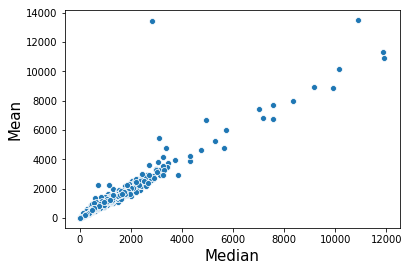

In [174]:
print("The median vs mean values of the products show positive correlation.\nTo reduce the outliers, the median was used")
sns.scatterplot(non_zero_volume_prod.groupby('category_name')['volume'].median(),non_zero_volume_prod.groupby('category_name')['volume'].mean())
plt.xlabel("Median", size=15)
plt.ylabel("Mean", size=15)

In [175]:
nonzero_median_vol = non_zero_volume_prod.groupby('category_name', as_index=False)['volume'].median()

In [176]:
median_volumes = nonzero_median_vol[nonzero_median_vol['category_name'].isin(categories_zero_vol)]

In [177]:
def update_type(t1, t2, val, dropna=False):
    return t1.map(t2).dropna() if dropna else t1.map(t2).fillna(val)

In [178]:
updated_vols = update_type(zvol_prod.category_name,
            median_volumes.set_index('category_name').volume, val=7.658600e+02)

In [179]:
updated_vols.head(10)

0    1430.92
1    1533.48
2    1533.48
3    1836.87
4    1843.17
5     982.13
6    2882.06
7    2663.62
8     629.77
9     466.79
Name: category_name, dtype: float64

In [180]:
df_detail_fin.loc[updated_vols.index,'volume'] = updated_vols.values

In [181]:
df_detail_fin[df_detail_fin['volume']!=0.0]['volume'].describe()

count    4.877190e+06
mean     1.946116e+03
std      2.275471e+03
min      7.000000e-02
25%      7.850000e+02
50%      1.430920e+03
75%      2.342620e+03
max      3.840040e+05
Name: volume, dtype: float64

In [182]:
df_temp_det = df_detail_fin[['order_id','replaceable', 'quantity_found', 'volume']]

In [183]:
df_temp_det['total_volume'] = df_temp_det.quantity_found * df_temp_det.volume

/Users/gionata/github/analitico/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [184]:
df_items = df_temp_det.groupby(['order_id'])['quantity_found'].count().to_frame().reset_index()
df_amount = df_temp_det.groupby(['order_id'])['quantity_found'].sum().to_frame().reset_index()
df_tot_volume = df_temp_det.groupby(['order_id'])['total_volume'].sum().to_frame().reset_index()

In [185]:
df_items = df_items.rename(index=str, columns={'order_id': 'id', 'quantity_found': 'items_found'})
df_amount = df_amount.rename(index=str, columns={'order_id': 'id', 'quantity_found': 'total_amount'})
df_tot_volume = df_tot_volume.rename(index=str, columns={'order_id': 'id', 'quantity_found': 'total_volume'})

In [186]:
df_tot_volume.columns

Index(['id', 'total_volume'], dtype='object')

In [187]:
df_final = pd.merge(df_final, df_items, on='id')

In [188]:
df_final = pd.merge(df_final, df_amount, on='id')

In [189]:
df_final = pd.merge(df_final, df_tot_volume, on='id')

In [190]:
df_final

,id,store_id,customer_id,courier_id,picker_id,fulfillment_type,status,deliver_at_start,deliver_at_end,amount,...,assigned_at,picked_at,paid_at,delivered_at,picking_time,paying_time,delivery_time,items_found,total_amount,total_volume
0,120402,100438,100446,42378,\N,1,600,2016-05-10 13:00:00,2016-05-10 14:00:00,35.51,...,2016-05-10 00:16:47,\N,2016-05-10 13:34:11,2016-05-10 13:40:33,15.73,0.28,6.37,11,21.000,31857.30000
1,120404,100440,100448,51236,\N,1,600,2016-05-12 20:00:00,2016-05-12 21:00:00,29.13,...,2016-05-10 00:42:31,\N,2016-05-12 20:07:18,2016-05-12 20:27:28,31.97,9.30,20.17,16,18.000,37498.11000
2,120408,100444,100452,53458,\N,1,600,2016-05-10 10:00:00,2016-05-10 11:00:00,22.83,...,2016-05-10 08:47:28,\N,2016-05-10 10:29:41,2016-05-10 11:00:07,9.37,10.58,30.43,11,12.000,23429.19000
3,120410,100446,100454,36412,\N,1,600,2016-05-10 12:00:00,2016-05-10 13:00:00,124.03,...,2016-05-10 03:17:08,\N,2016-05-10 12:14:33,2016-05-10 12:37:22,77.88,25.87,22.82,46,52.000,63217.34000
4,120414,100450,100458,1149,\N,1,600,2016-05-10 10:00:00,2016-05-10 11:00:00,28.30,...,2016-05-10 07:05:43,\N,2016-05-10 10:50:06,2016-05-10 11:12:35,12.33,13.83,22.48,9,12.000,23313.72000
5,120416,100452,100460,48948,\N,1,600,2016-05-10 15:00:00,2016-05-10 16:00:00,92.63,...,2016-05-10 06:59:00,\N,2016-05-10 14:38:29,2016-05-10 15:09:16,34.20,11.62,30.78,20,38.000,54803.07000
6,120418,100454,100462,53176,\N,1,600,2016-05-13 10:00:00,2016-05-13 11:00:00,12.72,...,2016-05-10 07:01:28,\N,2016-05-13 09:54:19,2016-05-13 10:09:27,12.75,14.07,15.13,8,7.000,14120.60000
7,120424,100460,100468,55384,\N,1,600,2016-05-10 10:00:00,2016-05-10 11:00:00,24.98,...,2016-05-10 07:45:56,\N,2016-05-10 10:30:18,2016-05-10 10:59:02,25.50,10.73,28.73,11,11.000,17849.92000
8,120428,100464,100472,35964,\N,1,600,2016-05-10 15:00:00,2016-05-10 16:00:00,67.69,...,2016-05-10 07:47:46,\N,2016-05-10 14:34:57,2016-05-10 15:05:02,17.63,0.33,30.08,24,31.000,52929.54000
9,120430,100466,100474,42150,\N,1,600,2016-05-10 12:00:00,2016-05-10 13:00:00,165.16,...,2016-05-10 07:59:20,\N,2016-05-10 11:03:23,2016-05-10 11:41:40,39.87,21.82,38.28,24,40.000,61520.37000


### GET ZTL FROM CUSTOMER TABLE

ZTL areas could be valuable to infer the total time for a delivery

In [191]:
ztl_col = update_type(df_final.customer_id, df_cust.set_index('id').ztl, val=0)
ztl_col

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
          ..
232258     0
232259     0
232260    20
232261     0
232262     0
232263     0
232264    20
232265     0
232266     0
232267     0
232268     0
232269     0
232270     0
232271     0
232272     0
232273     0
232274     0
232275     0
232276     0
232277     0
232278     0
232279     0
232280    20
232281     0
232282     0
232283     0
232284     0
232285     0
232286     0
232287     0
Name: customer_id, Length: 232288, dtype: int64

In [192]:
temp_vals = ztl_col.values
temp_vals = [0 if int(i)==0 else 1 for i in temp_vals]

In [193]:
ztl_col.update(pd.Series(temp_vals))

In [194]:
ztl_col

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
232258    0
232259    0
232260    1
232261    0
232262    0
232263    0
232264    1
232265    0
232266    0
232267    0
232268    0
232269    0
232270    0
232271    0
232272    0
232273    0
232274    0
232275    0
232276    0
232277    0
232278    0
232279    0
232280    1
232281    0
232282    0
232283    0
232284    0
232285    0
232286    0
232287    0
Name: customer_id, Length: 232288, dtype: int64

In [195]:
df_final.insert(loc=4, column='ztl', value=ztl_col) 

### INCLUDE COURIER EXPERIENCE

One could imagine a negative correlation exists between the experience of a customer (the total usage of the app 
for the delivery) and the picking time

In [196]:
df_final.courier_id=pd.to_numeric(df_final.courier_id)

In [197]:
df_cour_active = df_cour[df_cour.id.isin(df_final.courier_id.values)]

In [198]:
temp_exp = update_type(df_final.courier_id, df_cour_active.set_index('id').orders_sent, val=0)

In [199]:
df_final.insert(loc=4, column='courier_exp', value=temp_exp)

In [200]:
df_final.head()

,id,store_id,customer_id,courier_id,courier_exp,ztl,picker_id,fulfillment_type,status,deliver_at_start,...,assigned_at,picked_at,paid_at,delivered_at,picking_time,paying_time,delivery_time,items_found,total_amount,total_volume
0,120402,100438,100446,42378,6241.0,0,\N,1,600,2016-05-10 13:00:00,...,2016-05-10 00:16:47,\N,2016-05-10 13:34:11,2016-05-10 13:40:33,15.73,0.28,6.37,11,21.0,31857.30
1,120404,100440,100448,51236,8287.0,0,\N,1,600,2016-05-12 20:00:00,...,2016-05-10 00:42:31,\N,2016-05-12 20:07:18,2016-05-12 20:27:28,31.97,9.30,20.17,16,18.0,37498.11
2,120408,100444,100452,53458,2103.0,0,\N,1,600,2016-05-10 10:00:00,...,2016-05-10 08:47:28,\N,2016-05-10 10:29:41,2016-05-10 11:00:07,9.37,10.58,30.43,11,12.0,23429.19
3,120410,100446,100454,36412,526.0,0,\N,1,600,2016-05-10 12:00:00,...,2016-05-10 03:17:08,\N,2016-05-10 12:14:33,2016-05-10 12:37:22,77.88,25.87,22.82,46,52.0,63217.34
4,120414,100450,100458,1149,387.0,0,\N,1,600,2016-05-10 10:00:00,...,2016-05-10 07:05:43,\N,2016-05-10 10:50:06,2016-05-10 11:12:35,12.33,13.83,22.48,9,12.0,23313.72


### Convert distance and time to KMs and minutes respectively

In [201]:
df_final['store_customer_duration'] = pd.to_numeric(df_final['store_customer_duration'])

In [202]:
df_final['store_customer_duration'].head()

0    198
1    661
2    951
3    686
4    741
Name: store_customer_duration, dtype: int64

In [203]:
df_final.loc[:,'store_customer_duration'] /= 60 

In [204]:
df_final.store_customer_duration.head()

0     3.300000
1    11.016667
2    15.850000
3    11.433333
4    12.350000
Name: store_customer_duration, dtype: float64

In [205]:
df_final['store_customer_distance'].head()

0    1020
1    4908
2    4519
3    5991
4    6073
Name: store_customer_distance, dtype: int64

In [206]:
df_final.loc[:, 'store_customer_distance'] /= 1000

In [207]:
df_final.store_customer_distance.head()

0    1.020
1    4.908
2    4.519
3    5.991
4    6.073
Name: store_customer_distance, dtype: float64

### STORES TABLE

In [208]:
stores_head = ['id', 'province', 'lat', 'lng', 'area', 'ref_id', 'created_at', 'updated_at']
%time df_stores = pd.read_csv(filepath_or_buffer="./Data/store.csv")
df_stores.columns = stores_head
print("Shape ", df_stores.shape)
df_stores.head()

CPU times: user 681 ms, sys: 76.1 ms, total: 758 ms
Wall time: 757 ms
Shape  (388907, 8)


<string>:2: DtypeWarning:

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.



,id,province,lat,lng,area,ref_id,created_at,updated_at
0,52,MO,44.643322,10.957956,\N,4029,2015-05-20 17:47:58,2015-05-20 17:47:58
1,58,RM,41.898420,12.427509,\N,399,2015-05-21 08:39:31,2015-05-21 08:39:31
2,60,MI,45.490950,9.240785,\N,3214,2015-05-21 09:39:06,2015-05-21 09:39:06
3,62,RM,41.865984,12.486474,\N,320,2015-05-21 10:23:26,2015-05-21 10:23:26
4,74,TO,45.081251,7.636392,\N,1329,2015-05-22 11:39:21,2015-05-22 11:39:21


In [209]:
types_stores = df_stores.columns.to_series().groupby(df_stores.dtypes).groups
types_stores

{dtype('int64'): Index(['id'], dtype='object'),
 dtype('float64'): Index(['lat', 'lng'], dtype='object'),
 dtype('O'): Index(['province', 'area', 'ref_id', 'created_at', 'updated_at'], dtype='object')}

#### GET AN ESTIMATE OF THE MEAN SPEED FOR A DELIVERY AS A REFERENCE

In this section an estimate of the mean speed of a delivery (driving time) was made, in order to detect outliers 
when comparing the actual speed of delivery:
- estimated_speed = store_customer_distance/store_customer_duration
- actual_speed = store_customer_distance/delivery_time     

In [210]:
df_final = df_final[(df_final['store_customer_distance']!=0) & (df_final['store_customer_duration']!=0)]

The speed in the plots below is given in km/h

In [211]:
deliv_t = df_final['store_customer_duration'] / 60
dist_x = df_final['store_customer_distance']
vel_estimate = dist_x / deliv_t

DescribeResult(nobs=232280, minmax=(3.8716981132075476, 103.74485476037752), mean=26.246427243878806, variance=95.64737220441259, skewness=1.409068198219917, kurtosis=2.4675817058423384)

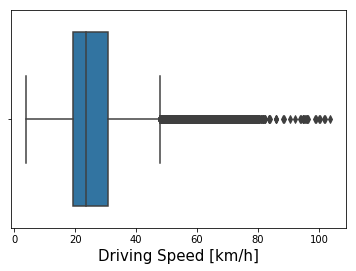

In [212]:
from scipy.stats import describe
from statsmodels import robust
sns.boxplot(vel_estimate)
plt.xlabel("Driving Speed [km/h]", size=15)
describe(vel_estimate)

In [213]:
print(f"Median {np.median(vel_estimate)} - median absolute deviation {robust.mad(vel_estimate)}")
med_abs_dev = robust.mad(vel_estimate)

Median 23.686588763425508 - median absolute deviation 7.720965434526687


Here below the distribution of the predicted driving speed

In [214]:
predict_t = df_final['delivery_time'] / 60
vel_predict = dist_x / predict_t

DescribeResult(nobs=232280, minmax=(1.4371904579688066e-05, 19745.399999999998), mean=17.921738364767325, variance=22093.81697705941, skewness=56.508422652591385, kurtosis=4831.394486706982)

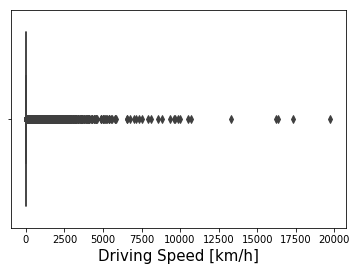

In [215]:
sns.boxplot(vel_predict)
plt.xlabel("Driving Speed [km/h]", size=15)
describe(vel_predict)

In [216]:
vel_estimate.index.equals(vel_predict.index)

True

In [217]:
df_speed = pd.DataFrame(dict(est = vel_estimate, pred = vel_predict))

In [218]:
df_speed.describe()

,est,pred
count,232280.000000,232280.000000
mean,26.246427,17.921738
std,9.779947,148.639890
min,3.871698,0.000014
25%,19.257099,5.740630
50%,23.686589,9.877723
75%,30.762204,15.611690
max,103.744855,19745.400000


Here the assumption is that if the estimated speed plus a median absolute deviation is lower than the actual speed, 
the datum is considered as an outlier. Also, if the predicted speed is too low (less than 1km/h)
and the estimated is one median absolute deviation away from it, the datum is still an outlier.

In [219]:
### get indices where the expected speed + 2 med abs dev is less than the predicted one
speed_idx_to_discard = df_speed[(df_speed['est'] + med_abs_dev < df_speed['pred']) | ((df_speed['pred'] < 1.) & (df_speed['est'] > 1. + med_abs_dev))].index

In [220]:
df_final.shape

(232280, 32)

In [221]:
speed_idx_to_discard

Int64Index([    35,     36,     43,     67,     84,     88,    109,    112,
               119,    120,
            ...
            231897, 232008, 232017, 232021, 232022, 232030, 232127, 232195,
            232260, 232284],
           dtype='int64', length=10960)

In [222]:
df_speed = df_speed[~df_speed.index.isin(speed_idx_to_discard)]

In [223]:
df_final = df_final[~df_final.index.isin(speed_idx_to_discard)]

In [224]:
df_final.shape

(221320, 32)

#### Further Subsetting: 1st version of the model is conservative - deliveries which take more than 60minutes of driving within a a 50kms distance time are discarded in this version of the dataset

In [225]:
df_subset = df_final[(df_final.delivery_time<60) & (df_final.store_customer_distance<50)]

In [226]:
df_subset.shape

(207842, 32)

#### Subset the delivery types with just the shopper

In [227]:
df_sub_shopper = df_subset[df_subset.fulfillment_type==1]

Sort values according to the date and time

In [228]:
df_sub_shopper = df_sub_shopper.sort_values(by='deliver_at_start')

#### Delete Duplicates of Couriers Doing Multiple Deliveries in 1 go (difficult to have reliable quick estimate of ETOT)

In [229]:
test_df = df_sub_shopper.drop_duplicates(subset=['deliver_at_start','courier_id'], keep=False)

#### Subset Deliveries not Moved

In [230]:
test_df = test_df[test_df.delivery_moved==0]

In [231]:
test_df = test_df.drop(columns=['picker_id', 'volume', 'created_at', 'assigned_at', 
                      'picked_at', 'gdo', 'vertical', 'deleted',
                      'delivery_cost_fixed_original', 'delivery_cost_discount','delivery_moved'])

In [232]:
test_df = test_df.dropna()

In [233]:
np.percentile(test_df.picking_time, 95), np.percentile(test_df.paying_time, 95), np.percentile(test_df.delivery_time, 95)

(63.10200000000012, 30.721000000000057, 46.78)

#### Keep values of the picking_time, paying_time and delivery_time that are within the 95% of the distribution

In [234]:
test_df = test_df[(test_df['picking_time']<np.percentile(test_df.picking_time, 95)) & (test_df['paying_time']<np.percentile(test_df.paying_time, 95)) & (test_df['delivery_time']<np.percentile(test_df.delivery_time, 95))]

In [235]:
test_df.shape

(146424, 21)

/Users/gionata/github/analitico/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



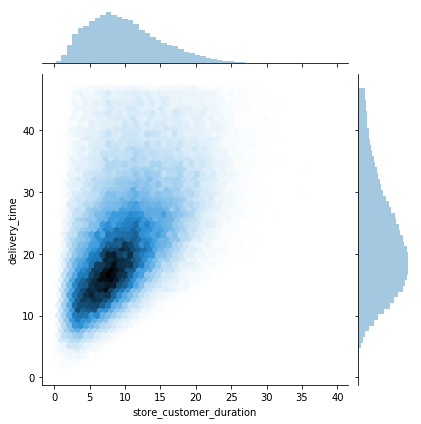

In [236]:
sns.jointplot(test_df.store_customer_duration, test_df.delivery_time, kind='hex')

#### Subset picking time and paying time lower than 1hour

In [237]:
test_df = test_df[(test_df.picking_time<60) & (test_df.paying_time<60)]

### More Data Cleaning

In [238]:
test_df.shape

(145160, 21)

In [239]:
df_total = test_df.copy()

In [240]:
dayofweek = pd.to_datetime(df_total['deliver_at_end'])
df_total['day_of_the_week']= dayofweek.dt.day_name()

#### Aggregate picking time, paying and delivery in one variable: total_time

In [241]:
df_total['total_time'] = df_total[['picking_time', 'paying_time', 'delivery_time']].sum(axis=1)

In [242]:
hour_traffic = pd.to_datetime(df_total['paid_at'])

In [243]:
df_total.insert(loc=18, column='driving_hour', value=hour_traffic.dt.hour)
#df_total['driving_hour'] = hour_traffic.dt.hour

#### Add province as a categorical variable

In [244]:
final_form = pd.merge(df_total, df_stores[df_stores.id.isin(df_total['store_id'].values)][['id','province']].rename(index=str, columns={'id': 'store_id'}), on='store_id')

### Subset non zero store_customer_distances and times longer than 1 minute

In [245]:
final_form = final_form[(final_form['store_customer_distance']!=0) & (final_form['store_customer_duration']>1)]

In [246]:
final_form = final_form[final_form['picking_time']>1]

In [247]:
final_form = final_form[final_form['delivery_time']>1]

In [248]:
types = final_form.columns.to_series().groupby(final_form.dtypes).groups
types

{dtype('int64'): Index(['id', 'store_id', 'customer_id', 'courier_id', 'ztl',
        'fulfillment_type', 'status', 'driving_hour', 'items_found'],
       dtype='object'),
 dtype('float64'): Index(['courier_exp', 'amount', 'store_customer_distance',
        'store_customer_duration', 'picking_time', 'paying_time',
        'delivery_time', 'total_amount', 'total_volume', 'total_time'],
       dtype='object'),
 dtype('O'): Index(['deliver_at_start', 'deliver_at_end', 'paid_at', 'delivered_at',
        'day_of_the_week', 'province'],
       dtype='object')}

#### Check Correlations between times and distance

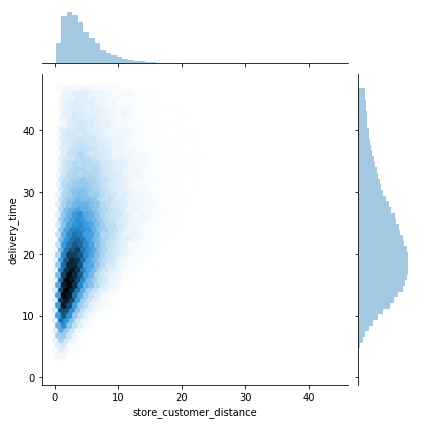

In [249]:
sns.jointplot(final_form['store_customer_distance'], final_form['delivery_time'], kind='hex')

/Users/gionata/github/analitico/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning:

JointGrid annotation is deprecated and will be removed in a future release.



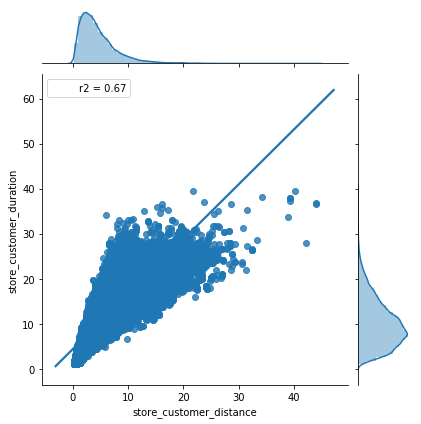

In [250]:
sns.jointplot(final_form.store_customer_distance, final_form.store_customer_duration, kind='reg', stat_func=r2)

#### Empirical Cumulative Distribution Function Plots - check for potential outliers

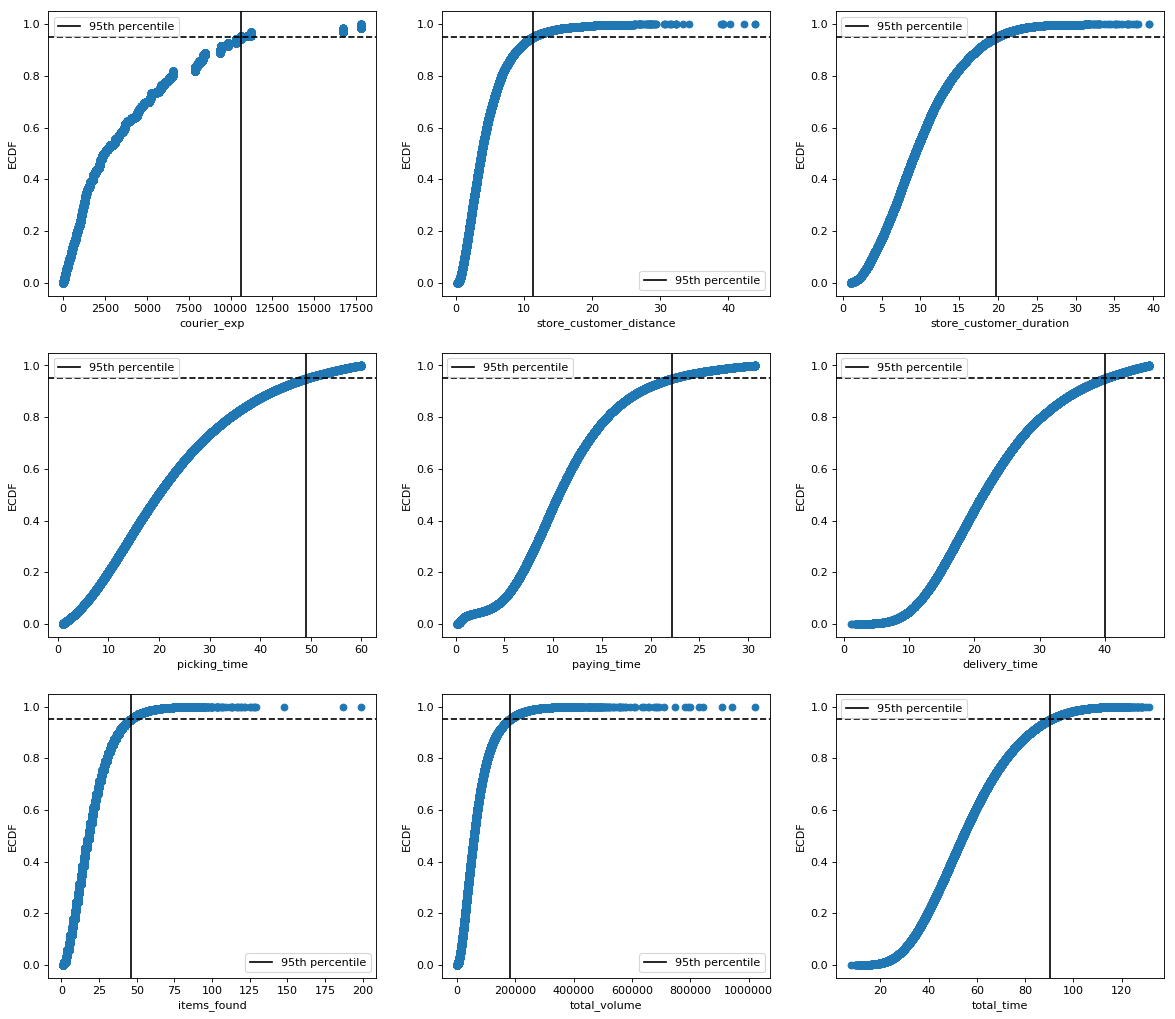

In [251]:
# Plotting the ECDF
cols_to_plot = ['courier_exp', 'store_customer_distance', 'store_customer_duration', 
                'picking_time', 'paying_time', 'delivery_time', 'items_found', 'total_volume', 'total_time']

plt.figure(figsize=(18, 16), dpi=80, facecolor='w', edgecolor='k')
for idx, col in enumerate(cols_to_plot):
    plt.subplot(3,3,idx+1)
    x = np.sort(final_form[col])
    y = np.arange(1, x.shape[0] + 1) / x.shape[0]
    # create ecdfplot
    plt.plot(x, y, marker='o', linestyle='')
    # add plot labels
    plt.ylabel('ECDF')
    plt.xlabel(col)
    eightieth_percentile = x[y <= 0.95].max()
    plt.axhline(0.95, color='black', linestyle='--')
    plt.axvline(eightieth_percentile, color='black', label='95th percentile')
    plt.legend()
plt.show()

#### Check higher density plot regions (optional & time consuming - can be skipped)

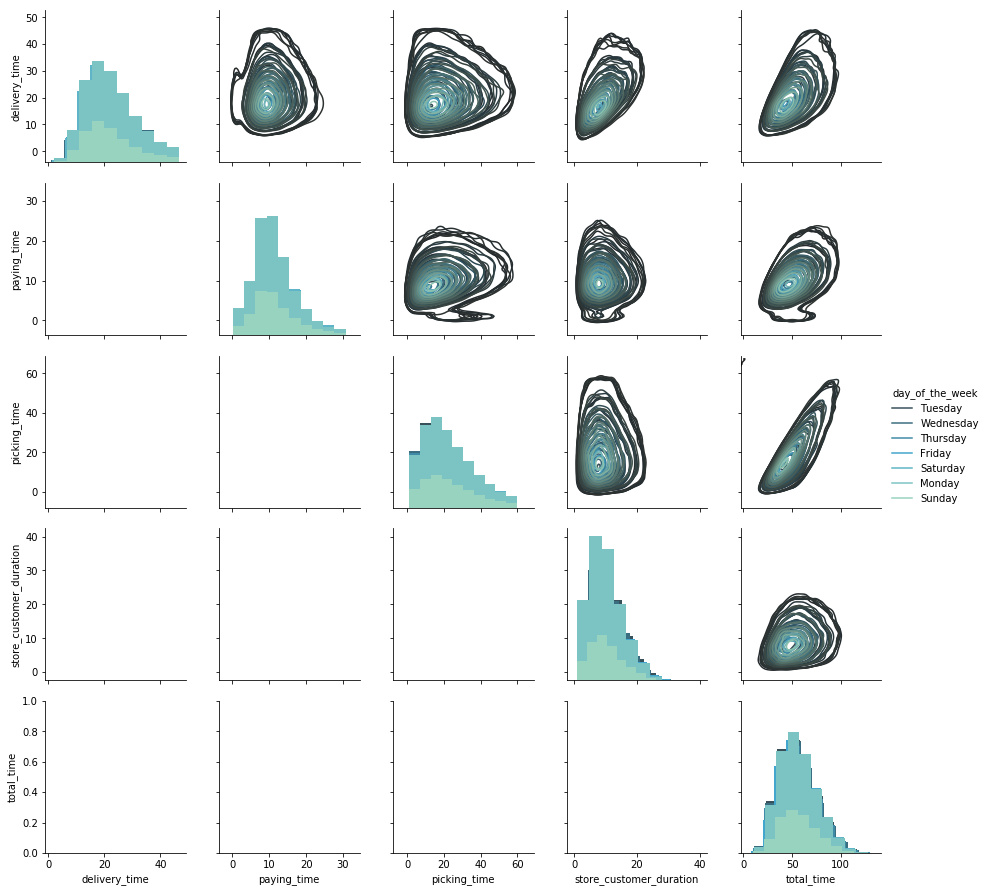

In [252]:
fig = sns.PairGrid(data=final_form[['delivery_time', 'paying_time', 
                                    'picking_time' , 'store_customer_duration', 'total_time',
                                    'day_of_the_week']], hue='day_of_the_week', palette="GnBu_d")
fig.map_diag(plt.hist)
#fig.map_lower()
fig.map_upper(sns.kdeplot)
fig.add_legend()

In [253]:
final_form.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140479 entries, 0 to 145159
Data columns (total 25 columns):
id                         140479 non-null int64
store_id                   140479 non-null int64
customer_id                140479 non-null int64
courier_id                 140479 non-null int64
courier_exp                140479 non-null float64
ztl                        140479 non-null int64
fulfillment_type           140479 non-null int64
status                     140479 non-null int64
deliver_at_start           140479 non-null object
deliver_at_end             140479 non-null object
amount                     140479 non-null float64
store_customer_distance    140479 non-null float64
store_customer_duration    140479 non-null float64
paid_at                    140479 non-null object
delivered_at               140479 non-null object
picking_time               140479 non-null float64
paying_time                140479 non-null float64
delivery_time              140479 non-nu

In [254]:
# feed_model = final_form[['total_time', 'amount','store_customer_distance','store_customer_duration','items_found', 'total_volume', 'courier_exp','day_of_the_week', 'ztl', 'driving_hour', 'province']]

### Keep Date (Month) of the Year as a categorical variable

In [255]:
final_form['date'] = final_form['delivered_at'].apply(pd.Timestamp).dt.date

In [256]:
final_form['month'] = pd.to_datetime(final_form['date']).dt.month_name()

In [257]:
final_form.date

0         2016-05-10
1         2016-05-10
2         2016-05-10
3         2016-05-10
4         2016-05-10
5         2016-05-10
7         2016-05-10
8         2016-05-10
9         2016-05-10
10        2016-05-10
11        2016-05-10
12        2016-05-10
14        2016-05-10
15        2016-05-10
16        2016-05-10
17        2016-05-10
18        2016-05-10
19        2016-05-10
20        2016-05-10
21        2016-05-10
22        2016-05-10
23        2016-05-10
24        2016-05-10
25        2016-05-10
27        2016-05-10
28        2016-05-10
29        2016-05-10
30        2016-05-10
31        2016-05-10
32        2016-05-10
             ...    
145130    2018-10-24
145131    2018-10-24
145132    2018-10-24
145133    2018-10-24
145134    2018-10-24
145135    2018-10-24
145136    2018-10-24
145137    2018-10-24
145138    2018-10-24
145139    2018-10-24
145140    2018-10-24
145141    2018-10-24
145142    2018-10-24
145143    2018-10-24
145144    2018-10-24
145145    2018-10-24
145146    201

In [258]:
final_form['driving_hour'] = final_form['driving_hour'].astype(str)

#### Drop province with little statistics (<1000 data) - high variability

In [259]:
drop_province = ['MN', 'PU', 'RA', 'PN', 'UD', 'CO', 'RM ']
final_form = final_form.drop(index=final_form[final_form['province'].isin(drop_province)].index)

#### Drop hour of the day with little statistics (<1000 data) - high variability

In [260]:
drop_times = ['7', '23', '22', '21']
final_form = final_form.drop(index=final_form[final_form['driving_hour'].isin(drop_times)].index)

In [261]:
feed_model = final_form[['total_time', 'amount','store_customer_distance','store_customer_duration','items_found', 'total_volume', 'courier_exp','day_of_the_week', 'ztl', 'driving_hour', 'province', 'month']]

In [262]:
feed_model.head()

,total_time,amount,store_customer_distance,store_customer_duration,items_found,total_volume,courier_exp,day_of_the_week,ztl,driving_hour,province,month
0,50.38,22.83,4.519,15.850000,11,23429.190,2103.0,Tuesday,0,10,MI,May
1,48.64,28.30,6.073,12.350000,9,23313.720,387.0,Tuesday,0,10,BS,May
2,64.96,24.98,8.132,11.183333,11,17849.920,4216.0,Tuesday,0,10,MI,May
3,23.56,18.74,0.709,2.800000,3,16605.480,1274.0,Tuesday,0,10,PD,May
4,43.94,25.00,4.211,8.666667,9,10763.445,452.0,Tuesday,0,10,BO,May


In [263]:
feed_model.shape

(137277, 12)

In [264]:
final_form.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137277 entries, 0 to 145159
Data columns (total 27 columns):
id                         137277 non-null int64
store_id                   137277 non-null int64
customer_id                137277 non-null int64
courier_id                 137277 non-null int64
courier_exp                137277 non-null float64
ztl                        137277 non-null int64
fulfillment_type           137277 non-null int64
status                     137277 non-null int64
deliver_at_start           137277 non-null object
deliver_at_end             137277 non-null object
amount                     137277 non-null float64
store_customer_distance    137277 non-null float64
store_customer_duration    137277 non-null float64
paid_at                    137277 non-null object
delivered_at               137277 non-null object
picking_time               137277 non-null float64
paying_time                137277 non-null float64
delivery_time              137277 non-nu

#### Convert categorical data to Dummy Variables - not ordinal (no ranking assigned to each variable)
Each single category is converted to a vector on 0s and 1s

In [265]:
datanew = pd.get_dummies(feed_model, drop_first=True)

In [266]:
datanew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137277 entries, 0 to 145159
Data columns (total 55 columns):
total_time                   137277 non-null float64
amount                       137277 non-null float64
store_customer_distance      137277 non-null float64
store_customer_duration      137277 non-null float64
items_found                  137277 non-null int64
total_volume                 137277 non-null float64
courier_exp                  137277 non-null float64
ztl                          137277 non-null int64
day_of_the_week_Monday       137277 non-null uint8
day_of_the_week_Saturday     137277 non-null uint8
day_of_the_week_Sunday       137277 non-null uint8
day_of_the_week_Thursday     137277 non-null uint8
day_of_the_week_Tuesday      137277 non-null uint8
day_of_the_week_Wednesday    137277 non-null uint8
driving_hour_11              137277 non-null uint8
driving_hour_12              137277 non-null uint8
driving_hour_13              137277 non-null uint8
driving_ho

#### Use ~80% of the data as a training set, and ~20% as a test set 

In [267]:
X_train = datanew.iloc[:110000,1:]
X_test = datanew.iloc[110000:,1:]
y_train = datanew.iloc[:110000,0]
y_test = datanew.iloc[110000:,0]

In [268]:
print(f"Compare the number of features in input: {X_train.shape[1]}\nWith the rank of the matrix: {np.linalg.matrix_rank(X_train)}\nMatching values mean that no linear dependence between the features is present")

Compare the number of features in input: 54
With the rank of the matrix: 54
Matching values mean that no linear dependence between the features is present


#### Dump the data extracted to save them

In [269]:
import pickle as pkl
pkl.dump([datanew, X_train, X_test, y_train, y_test], file=open("data_to_model.pkl", mode="wb"))

#### Explore Potential Correlations between features ab initio

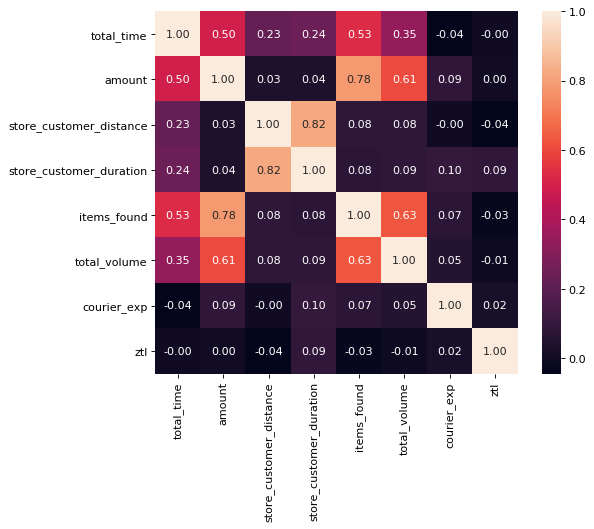

In [270]:
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
hm = sns.heatmap(feed_model.corr().values,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 yticklabels=feed_model.corr().columns,
                 xticklabels=feed_model.corr().columns)

# plt.savefig('images/10_04.png', dpi=300)
plt.show()